In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
EXTRACT_FEATURES = False
FEATURE_FILE_NAME = "inception_features.npy"
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
def load(fname,test=False, cols=None):
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(fname,test=False, cols=None):
    
    X, y, columns = load(fname,test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

def array_to_img(x):
#     rgbimg = cv2.resize(cv2.cvtColor(x,cv2.COLOR_GRAY2RGB),(224,224))
    rgbimg = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    rgbimg = rgbimg[...,::-1].astype(np.float32)
    a = np.expand_dims(rgbimg, axis=0)
    a = preprocess_input(a)
    return a

In [4]:
X, y, columns = load2d("data/training.csv",test=False)
columns = np.array(list(columns[:-1]))
columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
inception_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

In [19]:
json_file = open("face_model_in_cnn_ds.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("face_model_in_cnn_ds.h5")
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


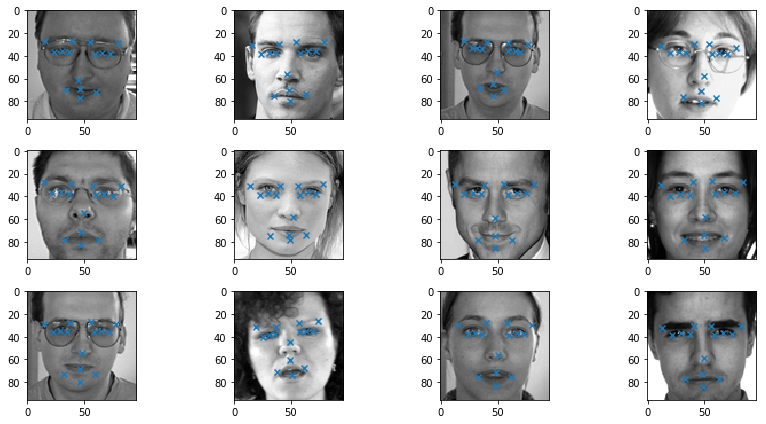

In [24]:
def keypoint_predict(x):
    img = array_to_img(x)
    features = (inception_model.predict(img)).flatten()
#     print(features.shape)
#     print(np.array([[features]]).shape)
    return model.predict(features.reshape(1,2048,1))[0]

import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X_test[i, :, :, 0], cmap="gray")
    p = keypoint_predict(X_test[i])
    plt.scatter(p[range(0, 30, 2)], p[range(1, 30, 2)], marker='x')

plt.tight_layout()
plt.show()

In [25]:
inception_features_array_test = np.zeros([X_test.shape[0],2048])
for i in range(X_test.shape[0]):
    img = array_to_img(X_test[i])
    features = inception_model.predict(img)
    inception_features_array_test[i] = features.flatten()

inception_features_array_test  = np.expand_dims(inception_features_array_test, axis=2)
score, acc = model.evaluate(inception_features_array_test,y_test)
print(score, acc)

321/321 [==============================] - 3s 11ms/step
7.443306296042564 0.6728971962616822
